<a href="https://www.kaggle.com/code/meltedbrain/trump-or-hairy-corn-on-the-cob?scriptVersionId=246488735" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Do you ever struggle to differentiate between President of the United States Donald Trump and hairy corn on the cob? 
Well fear not! This advanced DL model can do that for you! Gone are the days of uncertainty if what you're biting into is a temperamental cranky 60-year-old megalomaniac or simply a juicy slab of buttery goodness. Welcome to the era of perfect blond clarity. Simply snap a picture of the enigmatic, rich tangle in front of you and upload it to instantly settle your quandary!

> Make sure to enable a GPU accelerator in the "Settings" above.

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2' ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not cur

In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

## Step 1: Data Collection & Preprocessing

In [3]:
urls = search_images('trump photos', max_images=1)
urls[0]

'http://media.al.com/news_impact/photo/donald-trump-684c376f6a658f7c.jpg'

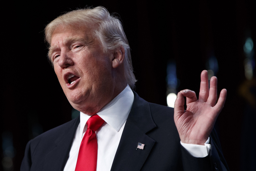

In [4]:
from fastdownload import download_url
dest = 'trump.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

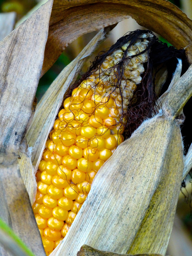

In [5]:
download_url(search_images('hairy corn on the cob photos', max_images=1)[0], 'hairy-corn-on-the-cob.jpg', show_progress=False)
Image.open('hairy-corn-on-the-cob.jpg').to_thumb(256,256)

In [6]:
searches = 'trump','hairy corn on the cob'
path = Path('trump_or_corn')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

## Step 2: Train Model

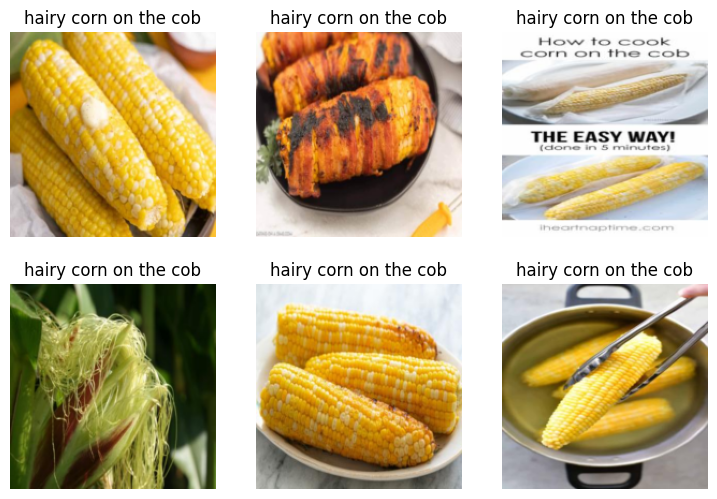

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.703930,0.024741,0.014085,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.077776,0.015893,0.014085,00:01
1,0.049126,0.029780,0.014085,00:01
2,0.042947,0.025304,0.014085,00:01


## Step 3: Predict

In [10]:
# Run this if you don't want to upload an image
uploader = SimpleNamespace(data = ['../input/example-image/corn.jpeg'])
img = PILImage.create(uploader.data[0])
is_trump,_,probs = learn.predict(img)
print(f"What is this?: {is_trump.capitalize()}.")
print(f"Probability it's Trump: {probs[1].item():.6f}")

What is this?: Hairy corn on the cob.
Probability it's Trump: 0.000667


In [11]:
import ipywidgets as widgets
uploader = widgets.FileUpload()
uploader

FileUpload(value=(), description='Upload')

In [12]:
# Uncomment to test using your own image
"""
img = PILImage.create(uploader.value[0].content.tobytes())
is_trump,_,probs = learn.predict(img)
print(f"What is this?: {is_trump.capitalize()}.")
print(f"Probability it's Trump: {probs[1].item():.6f}")
"""

'\nimg = PILImage.create(uploader.value[0].content.tobytes())\nis_trump,_,probs = learn.predict(img)\nprint(f"What is this?: {is_trump.capitalize()}.")\nprint(f"Probability it\'s Trump: {probs[1].item():.6f}")\n'